# CNN(Convolutional Neural Network)の実装

In [31]:
%matplotlib inline
import sys, os
sys.path.append("../../deep-learning-from-scratch/")
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

# im2col (image to column)関数の実装

In [32]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    input_data: 4D array (data size, channel, height, width)
    filter_h: height of filter
    filter_w: width of filter
    stride: stride
    pad: pading
    """
    
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride + 1
    
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], "constant")
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
            
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [33]:
#im2col関数の練習
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print("col1.shape: {}".format(col1.shape))

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print("col2.shape: {}".format(col2.shape))

col1.shape: (9, 75)
col2.shape: (90, 75)


In [49]:
#逆の処理　col2im(column to image)関数の実装

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride +1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    
    return img[:, :, pad:H +pad, pad:W + pad]

# Convolution Layer の実装

In [58]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        #中間データ
        self.x = None
        self.col = None
        self.col_W = None
        
        #重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None
       
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW =  self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

# Pooling Layer の実装

In [59]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        #画像をチャンネル毎に独立に展開
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        #max pooling のため、最大値を計算
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

# CNNの実装

In [60]:
#Convolution -> ReLU -> Pooling -> Affine -> ReLU -> Affine -> Softmax

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                            conv_param={"filter_num":30, "filter_size":5,
                            "pad":0, "stride":1}, 
                            hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2)*(conv_output_size/2))
        
        #重みパラメータの初期化
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params["b1"] = np.zeros(filter_num)
        self.params["W2"] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params["b2"] = np.zeros(hidden_size)
        self.params["W3"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b3"] = np.zeros(output_size)
        
        #レイヤの生成
        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(self.params["W1"], self.params["b1"], 
                                                                       conv_param["stride"], conv_param["pad"])
        self.layers["Relu1"] = Relu()
        self.layers["Pool1"] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers["Affine1"] = Affine(self.params["W2"], self.params["b2"])
        self.layers["Relu2"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["b3"])
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
       
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 

        return acc / x.shape[0]
            
    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
        return grads
    
    def gradient(self, x, t):
        #forward
        self.loss(x, t)
        
        #backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads["W1"] = self.layers["Conv1"].dW
        grads["b1"] = self.layers["Conv1"].db
        grads["W2"] = self.layers["Affine1"].dW
        grads["b2"] = self.layers["Affine1"].db
        grads["W3"] = self.layers["Affine2"].dW
        grads["b3"] = self.layers["Affine2"].db
        return grads
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

# CNNを用いたMNISTの学習

train loss:2.30028045674
=== epoch:1, train acc:0.16, test acc:0.173 ===
train loss:2.29705122273
train loss:2.29336896143
train loss:2.28473143353
train loss:2.28092040013
train loss:2.26842481618
train loss:2.24949890123
train loss:2.2363635813
train loss:2.22829537461
train loss:2.20345579775
train loss:2.11661393477
train loss:2.11942432534
train loss:2.03429806192
train loss:2.07316116345
train loss:1.96659096177
train loss:1.89370463227
train loss:1.81078105225
train loss:1.78826355485
train loss:1.66634131167
train loss:1.60892807161
train loss:1.53786895796
train loss:1.46547954273
train loss:1.28994482979
train loss:1.27197828009
train loss:1.23638866196
train loss:1.12740046369
train loss:1.14216730832
train loss:0.909205364243
train loss:1.00105800805
train loss:0.875470751154
train loss:0.820353403573
train loss:0.703620677201
train loss:0.841433880987
train loss:0.832192667165
train loss:0.754738109108
train loss:0.767927177242
train loss:0.878326812386
train loss:0.886858

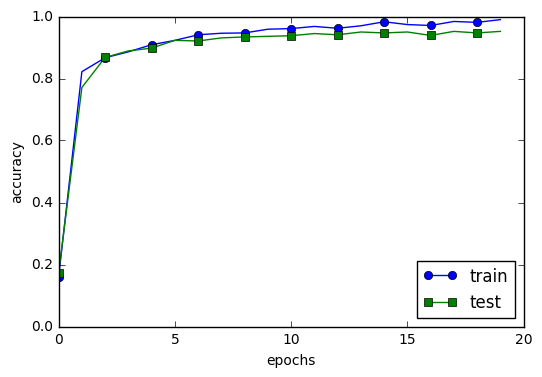

In [61]:
from dataset.mnist import load_mnist
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 計算時間を減らすため、データを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")
